<center><font size="6">Capstone: Classifying Multilabel Research Articles</font></center>
<center>Author : Teo Zhan Rui</center>



# Introduction

This classification task is a part of a hackathon hosted by Analytics Vidhya. With the explosion of data, research articles are also readily available on the internet. In order to aid in search, articles need to be labeled according to their relevant topics. 

https://datahack.analyticsvidhya.com/contest/janatahack-independence-day-2020-ml-hackathon/#SolutionChecker

I learnt from a recent career talk by a data scientist from Hello Health that one of the main tasks that the company undertakes is to classify health articles by topics, sometimes multilabel. Classification models have to build for each market and each language. This piqued my interest to take up this challenge.

https://hellohealthgroup.com

Multilabel classification poses additional challenges on top of multiclass problems as the targets are no longer mutually exclusive. An article can have more than 1 label akin to how a movie can be of action and comedy genre at the same time. 

In notebooks 1a) to 1c), I begin with Sklearn models to get a baseline micro f1-score. This is the metric chosen by the hackathon organizer and shall also be for evaluation of my models. Sklearn models support only binary or multiclass classification. In order to predict each of the 6 target labels, 6 models have to be built using the OneVsRest Classifier wrapper. Fundamentally, they are still not multilabel models. 

In notebooks 2a) to 2d), I explore 6 different neural networks with increasing complexities and then evaluate the best performing model. 

references:

https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/ 

https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314

https://github.com/adam0ling/twitter_sentiment

https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-04-text-classification.ipynb

## Problem Statement

1) What are the challenges of multilabel classification?

2) What are the suitable metrics for measuring performance?

3) Which model produced the best scores and are suitable for deployment?



## Executive Summary

**Results**

| library | model                                      |     type    | micro F1 | hamming loss | classes with nil prediction | lowest recall |
|---------|--------------------------------------------|:-----------:|:--------:|:------------:|:---------------------------:|:-------------:|
| sklearn | logistic regression                        | one vs rest |   0.799  |    0.0709    |              0              |     0.041     |
| sklearn | support vector machine                     | one vs rest |   0.811  |    0.0756    |              0              |     0.016     |
| keras   | simple neural network without word vectors |  multilabel |   0.798  |    0.0825    |              2              |     0.000     |
| keras   | simple RNN with LexVec                     |  multilabel |   0.677  |    0.1205    |              3              |     0.000     |
| keras   | LSTM and GRU with LexVec                   |  multilabel |   0.807  |    0.0776    |              0              |     0.066     |
| ktrain  | biGRU                                      |  multilabel |   0.82   |    0.0733    |              0              |     0.356     |
| ktrain  | BERT                                       |  multilabel |   0.825  |    0.0729    |              0              |     0.352     |
| ktrain  | distilBERT                                 |  multilabel |   0.833  |    0.0702    |              0              |     0.557     |

**Final Model Selection: distilBERT** <br>
The best performing model produced the highest micro F1 and lowest hamming loss. Also the lowest recall among 6 classes is **0.557** for the most poorly classified Quantitative Biology class, which is a marked improvement over all other models.


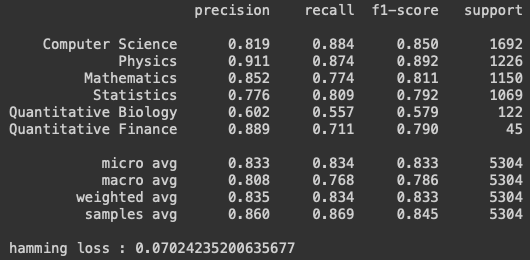

**Conclusions:**

1) Multilabel classification is an extension from binary or multiclass classification. However this project showed that good results can no longer be obtain easily from basic models. This is further exacerbated by presence of 2 minority classes of less than 3%.

2) Accuracy is not a suitable metric as a prediction is considered wrong for 1 single misclassified label out of any 6. Hence it is very punitive. 

Micro F1, which is the competition metric chosen by the hackathon organizers, measures all round performance. On the flipside, it can mask poor performance on minority. The recall score should be observed for every class. 

Hamming loss is easily understood and can be easily apply on individual prediction or across all predictions. 

3) Both distilBERT and BERT produced the best performances but BERT's space requirement is prohibitive. In addition, the output model of BERT is relatively large at 1.3 GB and that of distillBERT is about 250 MB.





**Suggested Further Study:**

1) Tune other hyperparameters such as optimizer and learning rates. 

2) Summarize text using BART of T5 to half the length and repeat training using BERT. 

3) Relabel or remove the data with obviously wrong ground truths. 

# Import

In [1]:
import numpy as np
import pandas as pd
import spacy
import re
import pickle
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, f1_score, hamming_loss
from sklearn.pipeline import Pipeline


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# EDA of train set

In [6]:
articles = pd.read_csv('/content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/datasets/train.csv')
#articles = pd.read_csv('./datasets/train.csv')

In [7]:
articles.shape

(20972, 9)

In [8]:
articles.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [9]:
articles.isnull().sum()

ID                      0
TITLE                   0
ABSTRACT                0
Computer Science        0
Physics                 0
Mathematics             0
Statistics              0
Quantitative Biology    0
Quantitative Finance    0
dtype: int64

In [10]:
articles.dtypes

ID                       int64
TITLE                   object
ABSTRACT                object
Computer Science         int64
Physics                  int64
Mathematics              int64
Statistics               int64
Quantitative Biology     int64
Quantitative Finance     int64
dtype: object

## Distribution of Labels and Classes

In [11]:
# compute the distribution of number of labels of each article
articles['num_labels'] = articles['Computer Science'] + articles['Physics'] + articles['Mathematics'] + \
                         articles['Statistics'] + articles['Quantitative Biology'] + \
                         articles['Quantitative Finance']

In [12]:
articles['num_labels'].value_counts()

1    15928
2     4793
3      251
Name: num_labels, dtype: int64

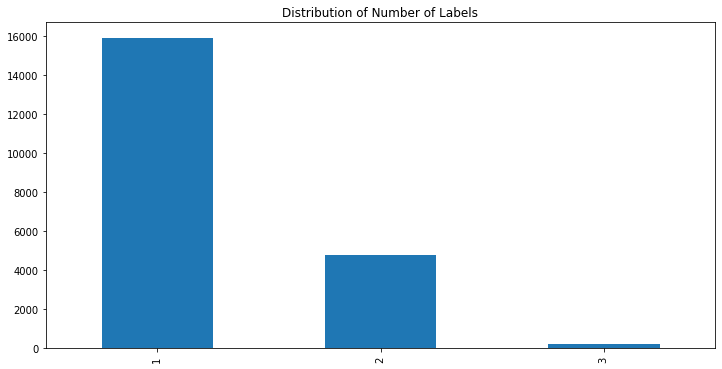

In [13]:
articles['num_labels'].value_counts().plot(kind='bar', figsize=(12,6), title='Distribution of Number of Labels');

Majority of data has 1 assigned label while a very small minority has 3 labels. 

In [14]:
articles[articles['num_labels']==2].head(10)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,num_labels
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,2
21,22,Many-Body Localization: Stability and Instability,Rare regions with weak disorder (Griffiths r...,0,1,1,0,0,0,2
28,29,Minimax Estimation of the $L_1$ Distance,We consider the problem of estimating the $L...,0,0,1,1,0,0,2
29,30,Density large deviations for multidimensional ...,We investigate the density large deviation f...,0,1,1,0,0,0,2
30,31,mixup: Beyond Empirical Risk Minimization,"Large deep neural networks are powerful, but...",1,0,0,1,0,0,2
35,36,Rate-Distortion Region of a Gray-Wyner Model w...,"In this work, we establish a full single-let...",1,0,1,0,0,0,2
43,44,Generalized Approximate Message-Passing Decode...,Sparse superposition (SS) codes were origina...,1,0,1,0,0,0,2
47,48,Wehrl Entropy Based Quantification of Nonclass...,Nonclassical states of a quantized light are...,1,1,0,0,0,0,2
50,51,Contextual Regression: An Accurate and Conveni...,Machine learning algorithms such as linear r...,1,0,0,1,0,0,2
58,59,Detecting Adversarial Samples Using Density Ra...,"Machine learning models, especially based on...",1,0,0,1,0,0,2


In [15]:
articles[articles['num_labels']==3].head(20)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,num_labels
72,73,Efficient and consistent inference of ancestra...,"In evolutionary biology, the speciation hist...",1,0,1,1,0,0,3
104,105,A Variational Characterization of Rényi Diverg...,"Atar, Chowdhary and Dupuis have recently exh...",1,0,1,1,0,0,3
186,187,Evaluating Roles of Central Users in Online Co...,Social media has changed the ways of communi...,1,1,0,1,0,0,3
276,277,Vocabulary-informed Extreme Value Learning,The novel unseen classes can be formulated a...,1,0,1,1,0,0,3
348,349,Ensemble Estimation of Mutual Information,We derive the mean squared error convergence...,1,0,1,1,0,0,3
511,512,Optimal Identity Testing with High Probability,We study the problem of testing identity aga...,1,0,1,1,0,0,3
569,570,Permutation Tests for Infection Graphs,We formulate and analyze a novel hypothesis ...,1,0,1,1,0,0,3
639,640,Smallest eigenvalue density for regular or fix...,The statistical behaviour of the smallest ei...,0,1,1,1,0,0,3
674,675,High Dimensional Robust Estimation of Sparse M...,We study the problem of sparsity constrained...,1,0,1,1,0,0,3
866,867,A Robust Multi-Batch L-BFGS Method for Machine...,This paper describes an implementation of th...,1,0,1,1,0,0,3


Most articles with multiple labels appear to belong to 'Computer Science', 'Mathematics' and 'Statistics'. 

In [16]:
labels = ['Computer Science','Physics','Mathematics','Statistics','Quantitative Biology','Quantitative Finance']
class_distribution = articles[labels].sum(axis=0)

In [19]:
class_distribution

Computer Science        8594
Physics                 6013
Mathematics             5618
Statistics              5206
Quantitative Biology     587
Quantitative Finance     249
dtype: int64

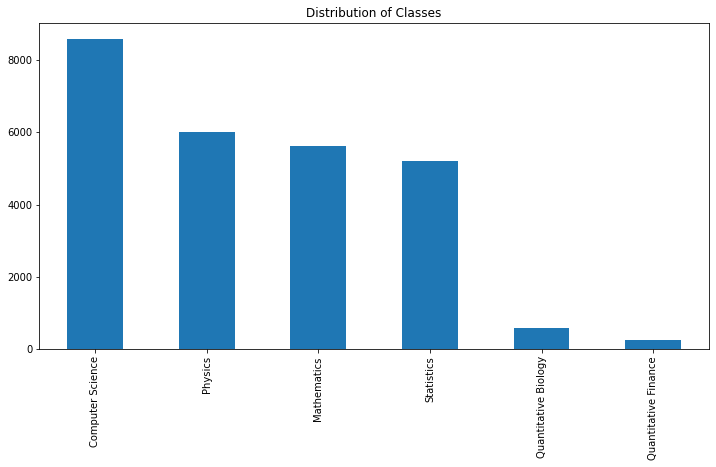

In [17]:
class_distribution.plot(kind='bar', figsize=(12,6), title='Distribution of Classes');

Quantitative Biology and Quantitive Finance are minority classes.

In [ ]:
articles[articles['Quantitative Biology']==1]['num_labels'].value_counts()

1    443
2    139
3      5
Name: num_labels, dtype: int64

141 Quantitative Finance articles are assigned to a second or third label.

In [ ]:
articles[articles['Quantitative Finance']==1]['num_labels'].value_counts()

1    209
2     37
3      3
Name: num_labels, dtype: int64

40 Quantitative Finance articles are assigned to a second or third label.

In [ ]:
# combine title and abstract to follow a single text for classification task
articles['merged'] = articles['TITLE'] + ' ' + articles['ABSTRACT']

## Text Features

In [ ]:
nlp = spacy.load('en_core_web_sm')
stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [ ]:
articles['merged'].str.contains('mathematical').sum()

469

In [ ]:
stopwords = stopwords.union({'computer','science','physics','mathematics',\
                             'statistics','statistic','statistical','quantitative',\
                             'biology','biological','finance'})

In [ ]:
'physics' in stopwords

True

In [ ]:
# custom function to preprocess text
def preprocess(text):
    # create Doc object
    doc = nlp(text, disable=['ner', 'parser'])
    # generate lemmas
    lemmas = [token.lemma_.lower() for token in doc]
    # remove stopwords and non-alphabetic characters
    alpha_lemmas = [lemma for lemma in lemmas 
            if lemma.isalpha() and lemma not in stopwords]
    return ' '.join(alpha_lemmas)

In [ ]:
# count number of words in each article
def num_words(text):
    words = text.split()
    return len(words)

In [ ]:
articles['num_words_original'] = articles['merged'].apply(num_words)

In [ ]:
articles['num_words_original'].max() , articles['num_words_original'].min()

(462, 5)

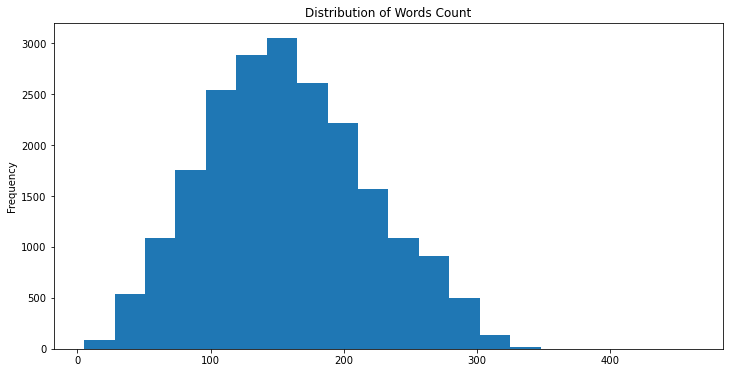

In [ ]:
articles['num_words_original'].plot(kind='hist', figsize=(12,6), title='Distribution of Words Count', bins=20);

In [ ]:
# this code takes about 10 to 12 min to run.
articles['processed'] = articles['merged'].apply(preprocess)

In [ ]:
articles['num_words_processed'] = articles['processed'].apply(num_words)

In [ ]:
articles['num_words_processed'].max() , articles['num_words_processed'].min()

(239, 4)

In [ ]:
articles.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,num_labels,merged,num_words_original,processed,num_words_processed
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,1,Reconstructing Subject-Specific Effect Maps ...,269,reconstruct subject specific effect map predic...,180
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,1,Rotation Invariance Neural Network Rotation ...,80,rotation invariance neural network rotation in...,49
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,1,Spherical polyharmonics and Poisson kernels fo...,107,spherical polyharmonic poisson kernel polyharm...,62
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,1,A finite element approximation for the stochas...,119,finite element approximation stochastic maxwel...,72
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,2,Comparative study of Discrete Wavelet Transfor...,145,comparative study discrete wavelet transforms ...,95


In [ ]:
#articles.to_csv('/content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/datasets/train_cleaned.csv', index=False)
articles.to_csv('./datasets/train_cleaned.csv', index=False)

# Sklearn Models

To obtain a basic feel of the data, I begin with Logistic Regression(LR) and Support Vector Machine(SVM). Naive Bayes Multinomial was used but did not yield good results compared to the first two so it was dropped. 

Due to their relatively low complexity, both LR and SVM have short run times. However, they do not natively support multilabel classification. Several common options are available in SkMultilearn in the Problem Transformation Section, namely ClassifierChain and LabelPowerset. These methods did not turn out better results, or worse still, caused memory issues due to much increased complexity.

Finally I settled for One Vs Rest(OVR) classifier which is implemented easily by wrapping LR and SVM in a typical pipeline. Fundamentally, OVR treats each class independently and trains 1 model for each class. While the API is easy to use, it comes with some downside which is slow prediction. 

## Logistic Regression

In [ ]:
#articles = pd.read_csv('/content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/datasets/train_cleaned.csv')
articles = pd.read_csv('./datasets/train_cleaned.csv')

In [ ]:
X = articles['processed']
y = articles[labels]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [ ]:
y_train.head()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
16466,0,0,0,0,0,1
4021,0,0,1,0,0,0
17248,1,0,0,0,0,0
17239,0,1,0,0,0,0
2966,0,1,0,0,0,0


In [ ]:
pipe_log = Pipeline([('tvec', TfidfVectorizer(ngram_range=(1, 1))),
                     ('log', OneVsRestClassifier(LogisticRegression(verbose=1, n_jobs=-1)))
                     ])
pipe_log.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


Pipeline(steps=[('tvec', TfidfVectorizer()),
                ('log',
                 OneVsRestClassifier(estimator=LogisticRegression(n_jobs=-1,
                                                                  verbose=1)))])

In [ ]:
%%timeit -r1 -n1
pipe_log.fit(X_train, y_train)

Logistic Regression is quite fast despite the need to generate 6 models, one for each target label.

In [ ]:
y_pred = pipe_log.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits = 3))
print('hamming loss : {} \n'.format(hamming_loss(y_test, y_pred)))

                      precision    recall  f1-score   support

    Computer Science      0.822     0.830     0.826      1692
             Physics      0.936     0.803     0.865      1226
         Mathematics      0.874     0.733     0.798      1150
          Statistics      0.828     0.664     0.737      1069
Quantitative Biology      0.625     0.041     0.077       122
Quantitative Finance      1.000     0.200     0.333        45

           micro avg      0.861     0.746     0.799      5304
           macro avg      0.848     0.545     0.606      5304
        weighted avg      0.858     0.746     0.790      5304
         samples avg      0.807     0.781     0.778      5304

hamming loss : 0.07902264600715136 



Observation: A micro F1-score of **0.799** shall serve as the baseline for now. However, we can observe that the recall for the 2 minority classes are very poor at 0.041 and 0.200 respectively. 

In [ ]:
#check for number of labels in test data.
print('Test Set:')
for i in range(4):
    n_labels = y_test[y_test.sum(axis=1)==i].shape[0]
    print('There are {} texts with {} label(s).'.format(n_labels, i))

Test Set:
There are 0 texts with 0 label(s).
There are 3141 texts with 1 label(s).
There are 999 texts with 2 label(s).
There are 55 texts with 3 label(s).


In [ ]:
y_pred_df = pd.DataFrame(y_pred, columns = labels)

#check for number of labels predicted for each text data.
print('Prediction:')
y_pred_df = pd.DataFrame(y_pred, columns = labels)
for i in range(4):
    n_labels = y_pred_df[y_pred_df.sum(axis=1) == i].shape[0]
    print('There are {} predictions with {} label(s).'.format(n_labels, i))


Prediction:
There are 357 predictions with 0 label(s).
There are 3096 predictions with 1 label(s).
There are 725 predictions with 2 label(s).
There are 17 predictions with 3 label(s).


In [ ]:
# extract the vocabulary and the respective coefficients
log_coefs = pipe_log.named_steps.log.coef_.T
log_features = pipe_log.named_steps.tvec.get_feature_names()

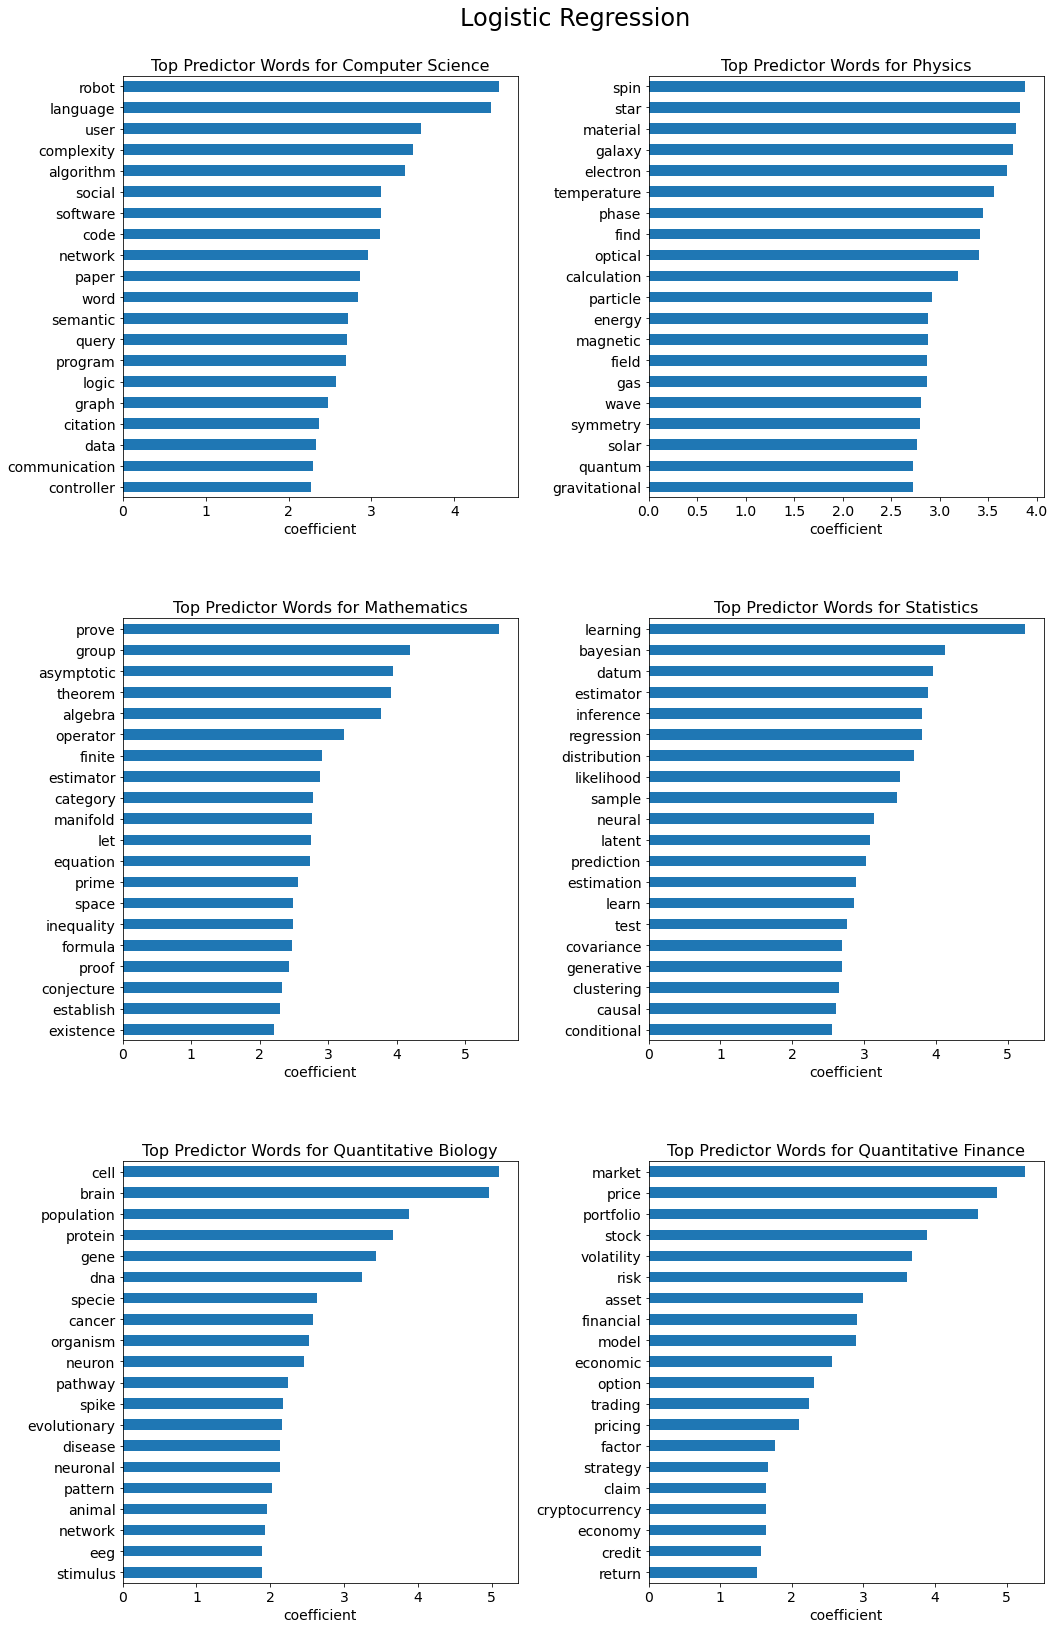

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 24)) 
fig.tight_layout(pad=10.0)
fig.suptitle('Logistic Regression', fontsize=24)
ax=ax.ravel()


for i in range(len(labels)):
    coefs_df = pd.Series(log_coefs[:,i], index = log_features)
    coefs_df.sort_values(ascending=True).tail(20).plot(kind = "barh", color ='tab:blue', ax=ax[i])
    ax[i].set_title('Top Predictor Words for '+labels[i], fontsize=16)
    ax[i].tick_params('x', labelsize=14)
    ax[i].tick_params('y', labelsize=14)
    ax[i].set_xlabel('coefficient', fontsize=14)


## Support Vector Machine

In [ ]:
pipe_svc = Pipeline([('tvec', TfidfVectorizer(ngram_range=(1, 1))),
                     ('svc', OneVsRestClassifier(SVC(verbose=1)))
                     ])
pipe_svc.fit(X_train, y_train)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

Pipeline(steps=[('tvec', TfidfVectorizer()),
                ('svc', OneVsRestClassifier(estimator=SVC(verbose=1)))])

In [ ]:
# filename = '/content/drive/MyDrive/Capstone - Multi Label Classification on Research Articles/models/sklearn OVR-SVM/svm.pkl'
filename = './models/sklearn OVR-svm/svm.pkl'

In [ ]:
# save model
pickle.dump(pipe_svc, open(filename, 'wb'))

In [ ]:
# load model
infile = open(filename, 'rb')
svc_model=pickle.load(infile)

In [ ]:
%%timeit -r1 -n1
svc_model.predict(X_test)

1min 35s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
y_pred = svc_model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred, target_names=labels, digits = 3))
print('hamming loss : {} \n'.format(hamming_loss(y_test, y_pred)))

                      precision    recall  f1-score   support

    Computer Science      0.819     0.859     0.839      1692
             Physics      0.939     0.820     0.875      1226
         Mathematics      0.874     0.738     0.801      1150
          Statistics      0.825     0.703     0.759      1069
Quantitative Biology      0.500     0.016     0.032       122
Quantitative Finance      0.917     0.244     0.386        45

           micro avg      0.858     0.768     0.811      5304
           macro avg      0.812     0.564     0.615      5304
        weighted avg      0.853     0.768     0.800      5304
         samples avg      0.821     0.802     0.795      5304

hamming loss : 0.07560588001589194 



Observation: Micro F1-score improved to **0.811**. However, we can observe that the recall for the 2 minority classes are still low at 0.016 and 0.244 respectively. 

Time taken to predict about 4000 texts is rather lengthy at 1 min 36s.

In [ ]:
#check for number of labels in test data.
print('Test Set:')
for i in range(4):
    n_labels = y_test[y_test.sum(axis=1)==i].shape[0]
    print('There are {} texts with {} label(s).'.format(n_labels, i))

Test Set:
There are 0 texts with 0 label(s).
There are 3141 texts with 1 label(s).
There are 999 texts with 2 label(s).
There are 55 texts with 3 label(s).


In [ ]:
y_pred_df = pd.DataFrame(y_pred, columns = labels)

#check for number of labels predicted for each text data.
print('Prediction:')
y_pred_df = pd.DataFrame(y_pred, columns = labels)
for i in range(4):
    n_labels = y_pred_df[y_pred_df.sum(axis=1) == i].shape[0]
    print('There are {} predictions with {} label(s).'.format(n_labels, i))


Prediction:
There are 291 predictions with 0 label(s).
There are 3078 predictions with 1 label(s).
There are 811 predictions with 2 label(s).
There are 15 predictions with 3 label(s).
